In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from tqdm import tqdm
from scipy.ndimage import gaussian_filter1d

In [2]:
torch.set_default_dtype(torch.double)

In [3]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"  # CPU is faster in our use case
print(f"Using {device} device")

Using cpu device


In [4]:
def train(dataloader, model, loss_fn, optimizer, print_frequency=0):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.force_non_negative_exponents_()

        if print_frequency > 0 and batch % print_frequency == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [5]:
def test(dataloader, model, loss_fn, print_loss=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    if print_loss:
        print(f"Test Error: Avg loss: {test_loss:>8f} \n")
    return test_loss

In [6]:
def tensor_to_numpy(tensor):
    return tensor.detach().cpu().numpy().copy()

class LogActivation(nn.Module):
    def forward(self, x):
        return torch.log(x)
        return torch.log(torch.maximum(x, torch.tensor(1e-10)))
    
class ExpActivation(nn.Module):
    def forward(self, x):
        return torch.exp(x)

# Define model
class PolynomialNN(nn.Module):
    def __init__(self, n_monomials=1, exponent_bias=True):
        super(PolynomialNN, self).__init__()
        self.stack = nn.Sequential(
            LogActivation(),
            nn.Linear(1, n_monomials, bias=exponent_bias),
            ExpActivation(),
            nn.Linear(n_monomials, 1)
        )
        self.exponent_bias = exponent_bias
        
    def forward(self, x):
        x = self.stack(x)
        return x
    
    @property
    def exponent_layer(self):
        return self.stack[1]
    
    @property
    def coefficient_layer(self):
        return self.stack[3]
    
    def get_exponents(self):
        return tensor_to_numpy(self.stack[1].weight)
    
    def get_coefficients(self):
        coefficients = tensor_to_numpy(self.coefficient_layer.weight)
        if self.exponent_bias:
            coefficients *= np.exp(tensor_to_numpy(self.exponent_layer.bias))
        return coefficients
    
    def get_bias(self):
        return tensor_to_numpy(self.coefficient_layer.bias)
    
    def exponents_abs_(self):
        self.exponent_layer.weight.abs_()
        
    def force_non_negative_exponents_(self):
        with torch.no_grad():
            self.exponent_layer.weight.clamp_(0.)

In [7]:
# Define Data
class DatasetFromFunction(Dataset):
    def __init__(self, sample_fn, target_fn, size, noise_fn = None, positive_only=False):
        self.x = sample_fn(size)[:, None]
        if positive_only:
            self.x = torch.abs(self.x)
        self.y = target_fn(self.x)
        self.noise = noise_fn(size) if noise_fn else torch.zeros_like(self.y)
        self.y += self.noise
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def normalize_target(self, mean, std):
        self.y = (self.y - mean)/std

In [8]:
def get_polynomial_fn(coefficients):
    def polynomial(x):
        val = 0
        for c in coefficients:
            val = val * x + c
        return val
    
    return polynomial

In [9]:
def truncated_normal(n, min_val, rng=None, mean=0., std=1.):
    normal_sample = lambda: torch.normal(mean, std, (n,), generator=rng)
    x = normal_sample()
    while (x < min_val).any():
        x_new = normal_sample()
        x[x < min_val] = x_new[x < min_val]
    return x

# Convergence Experiments

Generate the training and test set

Text(0.5, 1.0, 'Training Set')

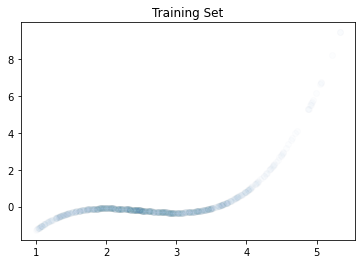

In [10]:
rng = torch.Generator(device="cpu")
rng.manual_seed(0)
sample_fn = lambda n: truncated_normal(n, 1, rng, mean=2.5)
coefficients = np.array([2, -15, 36, -25]).astype(np.float64)
poly_degree = len(coefficients) - 1
target_fn = get_polynomial_fn(coefficients)
training_data = DatasetFromFunction(sample_fn, target_fn, 1000)
val_data = DatasetFromFunction(sample_fn, target_fn, 100)
test_data = DatasetFromFunction(sample_fn, target_fn, 100)

# Normalize targets
target_mean = torch.mean(training_data.y)
target_std = torch.std(training_data.y)
training_data.normalize_target(target_mean, target_std)
val_data.normalize_target(target_mean, target_std)
test_data.normalize_target(target_mean, target_std)

train_dataloader = DataLoader(training_data, batch_size=128, shuffle=True)
val_dataloader = DataLoader(training_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

plt.scatter(training_data.x, training_data.y, alpha=0.01)
plt.title("Training Set")

Initialize the model

In [11]:
torch.manual_seed(68225)
n_coefficients = len(coefficients)
model = PolynomialNN(100, False).to(device)
with torch.no_grad():
    model.exponents_abs_()
print(model)

PolynomialNN(
  (stack): Sequential(
    (0): LogActivation()
    (1): Linear(in_features=1, out_features=100, bias=False)
    (2): ExpActivation()
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)


Train the model

In [12]:
loss_fn = nn.MSELoss()
exponent_path_list = [model.get_exponents()]
coefficient_path_list = [model.get_coefficients()]
bias_path_list = [model.get_bias()]
loss_path = [test(test_dataloader, model, loss_fn, False)]
total_epochs = 0

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=200, verbose=True, factor=0.1**(1/3))

In [14]:
epochs = 100000
for t in tqdm(range(epochs)):
    train(train_dataloader, model, loss_fn, optimizer)
    scheduler.step(test(val_dataloader, model, loss_fn, False))
    exponent_path_list.append(model.get_exponents())
    coefficient_path_list.append(model.get_coefficients())
    bias_path_list.append(model.get_bias())
    loss_path.append(test(test_dataloader, model, loss_fn, False))
    total_epochs += 1
test(test_dataloader, model, loss_fn)
print("Done!")

  3%|█▉                                                                   | 2804/100000 [00:38<22:25, 72.26it/s]

Epoch  2790: reducing learning rate of group 0 to 4.6416e-04.


  4%|███                                                                  | 4350/100000 [00:59<23:44, 67.12it/s]

Epoch  4342: reducing learning rate of group 0 to 2.1544e-04.


 38%|█████████████████████████▊                                          | 37963/100000 [09:20<15:32, 66.52it/s]

Epoch 37953: reducing learning rate of group 0 to 1.0000e-04.


100%|███████████████████████████████████████████████████████████████████| 100000/100000 [24:37<00:00, 67.69it/s]

Test Error: Avg loss: 0.000022 

Done!


Text(0.5, 1.0, 'Test Loss')

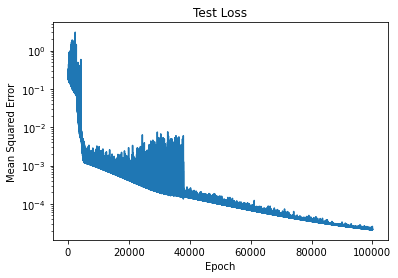

In [15]:
loss_start_epoch = 100
plt.plot(range(loss_start_epoch, total_epochs+1), loss_path[loss_start_epoch:])
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.yscale("log")
plt.title("Test Loss")

In [16]:
# Condense paths into arrays
exponent_path = np.stack(exponent_path_list)[:,:,0]
coefficient_path = np.stack(coefficient_path_list)[:,0,:]
bias_path = np.stack(bias_path_list)

# Sort from lowest to largest exponent
ind = np.argsort(exponent_path[-1])
exponent_path = exponent_path[:, ind]
coefficient_path = coefficient_path[:, ind]
coefficient_path = np.hstack([bias_path, coefficient_path])  # bias matches the oi-th degree coefficient

# Undo the target scaling for the coefficient path
coefficient_path *= target_std.numpy()
coefficient_path[:, 0] += target_mean.numpy()

In [34]:
smoothing_sd = .03  # used to determine the confidence interval of a learned exponent
max_plot_epochs = 1000  # determines how many epochs we sample
if max_plot_epochs < total_epochs:
    x = np.linspace(0, total_epochs, max_plot_epochs, dtype=np.int32)
else:
    x = np.arange(total_epochs+1)

exponent_bins = 1000
y_min = -4 * smoothing_sd
y_max = max(exponent_path.max(), poly_degree) + 4*smoothing_sd
learned = np.zeros((exponent_bins, x.size))
for i, epoch in enumerate(x):
    exponents = np.concatenate([[0], exponent_path[epoch]])
    weights = coefficient_path[epoch]
    hist, bin_edges = np.histogram(exponents, exponent_bins, (y_min, y_max), weights=weights)
    learned[:, i] = hist
learned = gaussian_filter1d(learned, smoothing_sd * exponent_bins/y_max, axis=0) 

hist, bin_edges = np.histogram(range(poly_degree+1)[::-1], exponent_bins, (y_min, y_max), weights=coefficients)
ground_truth = gaussian_filter1d(hist, smoothing_sd * exponent_bins/y_max, axis=0)
ground_truth = ground_truth[:, None]

y = bin_edges[:-1] + (bin_edges[1] - bin_edges[0])/2

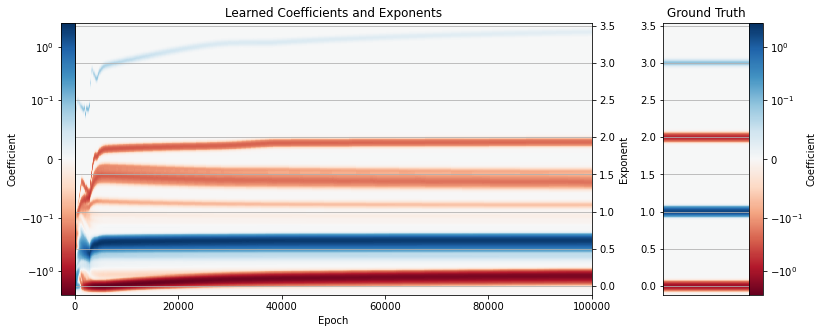

In [35]:
vmax = max(np.abs(learned).max(), ground_truth.max())
vmin = -vmax
norm = mcolors.SymLogNorm(0.1, vmin=vmin, vmax=vmax)
cmap = "RdBu"

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw=dict(width_ratios=[6,1]))
pcm = ax1.pcolormesh(x, y, learned, cmap=cmap, norm=norm, edgecolors=None)
fig.colorbar(pcm, ax=ax1, label="Coefficient", pad=0, location="left")
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")
ax1.set_ylabel("Exponent")
ax1.set_xlabel("Epoch")
ax1.set_title("Learned Coefficients and Exponents")
ax1.grid(True, axis='y')

pcm = ax2.pcolormesh([0,1], bin_edges, ground_truth, cmap=cmap, norm=norm, edgecolors=None)
fig.colorbar(pcm, ax=ax2, label="Coefficient", pad=0)
ax2.set_title("Ground Truth")
ax2.xaxis.set_visible(False)
ax2.grid(True, axis='y')

Text(0, 0.5, 'Coefficient Value')

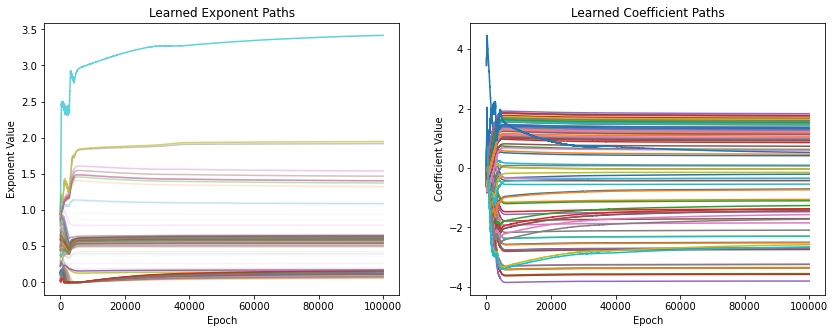

In [36]:
# Prepare for plotting
fig, ax = plt.subplots(1, 2, figsize = (14, 5))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Plot the exponents path
exponent_strength = np.abs(coefficient_path[-1])
exponent_strength /= exponent_strength.max()
for i, path in enumerate(exponent_path.T):
    ax[0].plot(path, c=colors[i % len(colors)], alpha=exponent_strength[i])

plot_bottom = ax[0].get_ylim()[0]
if plot_bottom > 0:
    ax[0].set_ylim(0)
        
ax[0].set_title("Learned Exponent Paths")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Exponent Value")

# Plot the coefficient paths
for degree, path in enumerate(coefficient_path.T):
    ax[1].plot(path, c=colors[degree % len(colors)])
        
ax[1].set_title("Learned Coefficient Paths")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Coefficient Value")

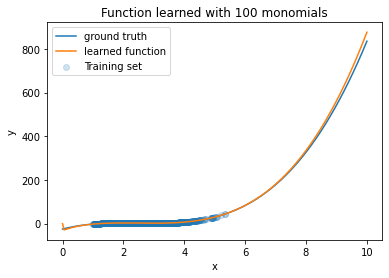

In [21]:
x = torch.from_numpy(np.linspace(0, 10, 200))
model.eval()
model.to('cpu')
pred = model(x[:,None]).detach()
model.to(device)
pred = pred * target_std + target_mean  # unnormalize prediction
train_y = training_data.y * target_std + target_mean


plt.plot(x, target_fn(x), label="ground truth")
plt.plot(x, pred, label="learned function")
plt.scatter(training_data.x, train_y, alpha=0.2, label="Training set")

plt.xlabel('x')
plt.ylabel('y')
plt.title(f"Function learned with {model.exponent_layer.out_features} monomials")
plt.legend()

In [22]:
model.get_exponents()

array([[1.32673145],
       [0.54850142],
       [0.600277  ],
       [0.63459431],
       [0.19554331],
       [0.62946034],
       [0.10782054],
       [0.14917694],
       [0.08934363],
       [1.4044743 ],
       [0.63031162],
       [0.54306094],
       [0.65339811],
       [0.63249123],
       [0.61543451],
       [0.14513225],
       [3.41671925],
       [1.0831942 ],
       [0.62289682],
       [0.64329631],
       [0.60493438],
       [0.64746875],
       [0.14953955],
       [0.1163942 ],
       [0.14893718],
       [0.94101294],
       [0.62124272],
       [1.46918393],
       [0.59759301],
       [1.91889996],
       [0.53696579],
       [0.61014278],
       [0.12597322],
       [0.09968649],
       [0.5942773 ],
       [0.59144406],
       [0.6288399 ],
       [0.6284597 ],
       [0.26929419],
       [0.14476275],
       [0.65225177],
       [1.5411386 ],
       [0.63066874],
       [0.58780535],
       [0.11709807],
       [0.59782739],
       [0.28958754],
       [0.069

In [23]:
model.get_coefficients()*target_std.numpy(), (model.get_bias()+target_mean.numpy())*target_std.numpy()

(array([[-1.2615352 ,  1.13110602,  1.59234734,  1.07518024, -0.35478389,
          1.61483527, -2.2866812 , -0.54062624, -1.84412924, -1.43034356,
          1.02219731,  1.29541125,  0.60317848,  1.770346  ,  1.20887128,
         -3.24364989,  0.5276839 , -0.70380055,  1.47932145,  1.76750071,
          1.63174122,  1.83151644, -3.3629345 , -2.49871738, -3.3465471 ,
         -0.34124831,  1.64040382, -1.5662893 ,  1.23379995, -2.57892532,
          1.13861985,  0.91595814, -2.74096639, -2.08950447,  1.51697128,
          1.37170255,  1.28032367,  1.67992076, -0.04040543, -3.23371363,
          0.73466145, -1.7197998 ,  1.64231016,  1.17288183, -2.51632227,
          1.49674745,  0.0975446 , -1.37971158, -2.69823593,  1.44696799,
          1.46658664, -2.68831471, -2.69836732,  0.85965733,  1.32893318,
          1.74820316,  1.2171195 ,  1.18293832,  1.46502307,  1.653064  ,
          1.1475545 ,  1.53912108, -1.43680699, -3.57644052,  1.01339244,
          1.52195183, -2.29760348, -1.